## User Behaviour on Twitter
Unsupervised clustering and interpreting.

In [1]:
#import libs
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import  tqdm #NOT NEEDED, JUST USED WHEN WRITING THE NOTEBOOK
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None  # default='warn'
np.random.seed(10)

In [2]:
#loading
egoalter = pd.read_csv('./EgoAlterProfiles.txt',delimiter='\t')
#egonet = pd.read_csv('./EgoNetworks.txt',delimiter='\t')
egotimes = pd.read_csv('./EgoTimelines.txt',delimiter='\t',encoding='latin-1')

In [3]:
# Apply the default theme
# sns.set_theme()

In [4]:
egoalter.head()

,ID,IsEgo,followers_count,friends_count,statuses_count,utc_offset,lang,created_at,protected
0,1,True,30.0,28,9.0,NaN,en,Wed Oct 26 03:30:32 +0000 2011,False
1,2,True,2.0,8,7.0,-14400.0,en,Mon Jul 27 20:46:32 +0000 2009,False
2,3,True,1.0,0,0.0,NaN,fr,Mon Apr 23 20:57:26 +0000 2012,False
3,4,True,3.0,3,68.0,NaN,en,Sun Feb 14 07:50:39 +0000 2010,False
4,5,True,65.0,118,748.0,NaN,fr,Mon Jun 11 14:17:06 +0000 2012,False


In [46]:
egotimes.head()

,replyto_userid,retweeted_userid,id,tweetid,created_at,hashtags,urls,mentions_ids,retweet_count,egoID,retweetedUserID,replytoUserID,metionID
0,NaN,NaN,398477318,249552537051598848,Sat Sep 22 16:55:35 +0000 2012,NaN,NaN,2810549959,0,1,NaN,NaN,NaN
1,NaN,NaN,398477318,249537963145433088,Sat Sep 22 15:57:41 +0000 2012,NaN,NaN,2810549959,0,1,NaN,NaN,NaN
2,NaN,NaN,398477318,129377372209299456,Thu Oct 27 02:02:23 +0000 2011,NaN,NaN,NaN,0,1,NaN,NaN,NaN
3,NaN,NaN,398477318,302401054690140160,Fri Feb 15 12:56:44 +0000 2013,NaN,NaN,797583722,0,1,NaN,NaN,1970142
4,NaN,NaN,398477318,249538739611787264,Sat Sep 22 16:00:46 +0000 2012,NaN,NaN,2810549959,0,1,NaN,NaN,NaN


In [5]:
egotimes[200:400]

,replyto_userid,retweeted_userid,id,tweetid,created_at,hashtags,urls,mentions_ids,retweet_count,egoID,retweetedUserID,replytoUserID,metionID
200,NaN,NaN,605458456,523333693134622720,Sat Oct 18 04:44:10 +0000 2014,NaN,NaN,131556965,0,5,NaN,NaN,2423603
201,NaN,162670016.0,605458456,413801463979458560,Thu Dec 19 22:42:11 +0000 2013,NaN,NaN,"162670016,424891673,324662307",5,5,NaN,NaN,1792569
202,NaN,NaN,605458456,527763081762717696,Thu Oct 30 10:04:58 +0000 2014,IciCestParis,NaN,NaN,0,5,NaN,NaN,NaN
203,NaN,NaN,605458456,527719935527878656,Thu Oct 30 07:13:31 +0000 2014,NaN,NaN,NaN,0,5,NaN,NaN,NaN
204,NaN,NaN,605458456,527252905972494338,Wed Oct 29 00:17:43 +0000 2014,NaN,NaN,NaN,0,5,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,NaN,NaN,605458456,424146092771778560,Fri Jan 17 11:48:03 +0000 2014,NaN,NaN,NaN,0,5,NaN,NaN,NaN
396,NaN,NaN,605458456,394447458828161025,Sun Oct 27 12:56:17 +0000 2013,skyrim,NaN,NaN,0,5,NaN,NaN,NaN
397,NaN,NaN,605458456,347778837368684544,Thu Jun 20 18:11:50 +0000 2013,NaN,http://t.co/n3Am0xdPgI,NaN,0,5,NaN,NaN,NaN
398,NaN,NaN,605458456,322070627999707136,Wed Apr 10 19:36:36 +0000 2013,BARCAPSG,NaN,NaN,0,5,NaN,NaN,NaN


### Features used for clustering
- followers count
- friends count
- followers-friends ratio
- proportion of tweets
- proportion of RT
- proportion of replies
- days since account creation
- average number of statuses per month
- average number of hashtags per post
- average number of URLs per post
- average number of mentions per post
- average number of retweets per tweet

In [6]:
def extract_info(df):
    
    n = len(df)
    n_replies = n - np.sum(df['replyto_userid'].isnull())
    n_rt = n - np.sum(df['retweeted_userid'].isnull())
    mentions = df[df['mentions_ids'].notnull()].mentions_ids
    n_mentions = len([x for xs in mentions for x in xs.split(',')])
    
    retweeted = np.nansum(df['retweet_count'])
    
    # number of hashtags
    hashtags = df[df['hashtags'].notnull()].hashtags
    n_hashtags = len([x for xs in hashtags for x in xs.split(',')])
    
    # number of urls per tweet
    urls = df[df['urls'].notnull()].urls
    n_urls = len([x for xs in urls for x in xs.split(',')])
    
    return n, n_replies, n_mentions, n_rt, n_hashtags, n_urls, retweeted

In [7]:
isEgo = egoalter.loc[egoalter['IsEgo']]

In [8]:
ego_intersect = set(egotimes['egoID'].unique()).intersection(set(isEgo['ID']))
columns = ['id','n_statuses', 'n_replies','n_mentions','n_rt','n_hashtags','n_urls','retweeted']
stats = pd.DataFrame(0, index=np.arange(len(ego_intersect)), columns=columns)

for i, _id in tqdm(enumerate(ego_intersect)):
    n, n_replies, n_mentions, n_rt, n_hashtags, n_urls, retweeted = extract_info(egotimes.loc[egotimes['egoID']==_id])
    stats.iloc[i].id = _id
    stats.iloc[i].n_statuses = n
    stats.iloc[i].n_replies = n_replies
    stats.iloc[i].n_mentions = n_mentions
    stats.iloc[i].n_rt = n_rt
    stats.iloc[i].n_hashtags = n_hashtags
    stats.iloc[i].n_urls = n_urls
    stats.iloc[i].retweeted = retweeted

17244it [02:11, 131.20it/s]


In [9]:
merged = isEgo.merge(stats, how='left', left_on='ID', right_on='id')
merged.head()

,ID,IsEgo,followers_count,friends_count,statuses_count,utc_offset,lang,created_at,protected,id,n_statuses,n_replies,n_mentions,n_rt,n_hashtags,n_urls,retweeted
0,1,True,30.0,28,9.0,NaN,en,Wed Oct 26 03:30:32 +0000 2011,False,1.0,9.0,4.0,8.0,0.0,0.0,0.0,0.0
1,2,True,2.0,8,7.0,-14400.0,en,Mon Jul 27 20:46:32 +0000 2009,False,2.0,7.0,2.0,2.0,0.0,1.0,3.0,0.0
2,3,True,1.0,0,0.0,NaN,fr,Mon Apr 23 20:57:26 +0000 2012,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,True,3.0,3,68.0,NaN,en,Sun Feb 14 07:50:39 +0000 2010,False,4.0,68.0,0.0,0.0,0.0,0.0,60.0,0.0
4,5,True,65.0,118,748.0,NaN,fr,Mon Jun 11 14:17:06 +0000 2012,False,5.0,742.0,334.0,375.0,103.0,118.0,29.0,26408.0


In [10]:
inactive = (merged.friends_count == 0) & (merged.followers_count == 0)
merged['followers_ratio'] = (merged['followers_count']/(merged['friends_count'] + 0.01))
merged.loc[inactive,'followers_ratio'] = 1

merged['n_tweets'] = merged['n_statuses'] - merged['n_replies'] - merged['n_rt']
merged['prop_tweets'] = merged['n_tweets']/merged['n_statuses']
merged['prop_replies'] = merged['n_replies']/merged['n_statuses']
merged['prop_rt'] = merged['n_rt']/merged['n_statuses']
merged['avg_hashtags'] = merged['n_hashtags']/merged['n_statuses']
merged['avg_urls'] = merged['n_urls']/merged['n_statuses']
merged['avg_mentions'] = merged['n_mentions']/merged['n_statuses']
merged['avg_retweeted'] = (merged['retweeted']/merged['n_tweets']).replace(np.inf, 0)
merged['created_at'] = pd.to_datetime(merged['created_at'], format='%a %b %d %H:%M:%S %z %Y')
end_date = merged.created_at.max()
merged['account_age_months'] = ((end_date - merged.created_at).dt.days/30) + 0.01
merged['statuses_per_month'] = merged['statuses_count']/merged['account_age_months']
merged.head()

,ID,IsEgo,followers_count,friends_count,statuses_count,utc_offset,lang,created_at,protected,id,n_statuses,n_replies,n_mentions,n_rt,n_hashtags,n_urls,retweeted,followers_ratio,n_tweets,prop_tweets,prop_replies,prop_rt,avg_hashtags,avg_urls,avg_mentions,avg_retweeted,account_age_months,statuses_per_month
0,1,True,30.0,28,9.0,NaN,en,2011-10-26 03:30:32+00:00,False,1.0,9.0,4.0,8.0,0.0,0.0,0.0,0.0,1.071046,5.0,0.555556,0.444444,0.000000,0.000000,0.000000,0.888889,0.000000,36.676667,0.245388
1,2,True,2.0,8,7.0,-14400.0,en,2009-07-27 20:46:32+00:00,False,2.0,7.0,2.0,2.0,0.0,1.0,3.0,0.0,0.249688,5.0,0.714286,0.285714,0.000000,0.142857,0.428571,0.285714,0.000000,64.010000,0.109358
2,3,True,1.0,0,0.0,NaN,fr,2012-04-23 20:57:26+00:00,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.643333,0.000000
3,4,True,3.0,3,68.0,NaN,en,2010-02-14 07:50:39+00:00,False,4.0,68.0,0.0,0.0,0.0,0.0,60.0,0.0,0.996678,68.0,1.000000,0.000000,0.000000,0.000000,0.882353,0.000000,0.000000,57.310000,1.186529
4,5,True,65.0,118,748.0,NaN,fr,2012-06-11 14:17:06+00:00,False,5.0,742.0,334.0,375.0,103.0,118.0,29.0,26408.0,0.550801,305.0,0.411051,0.450135,0.138814,0.159030,0.039084,0.505391,86.583607,29.010000,25.784212


In [11]:
cols = ['ID','followers_count','friends_count','statuses_count', 'account_age_months',
        'statuses_per_month','followers_ratio','prop_tweets', 'prop_replies','prop_rt',
        'avg_hashtags','avg_urls','avg_mentions']
features = merged[cols].fillna(0)

In [12]:
features.set_index('ID').describe()

,followers_count,friends_count,statuses_count,account_age_months,statuses_per_month,followers_ratio,prop_tweets,prop_replies,prop_rt,avg_hashtags,avg_urls,avg_mentions
count,34006.000000,34006.000000,3.400600e+04,34006.000000,34006.000000,34006.000000,34006.000000,34006.000000,34006.000000,34006.000000,34006.000000,34006.000000
mean,56.604511,68.490061,4.483272e+02,26.648642,16.856397,39.142005,0.323153,0.115620,0.068313,0.094698,0.096359,0.249363
std,953.436514,344.940809,6.748816e+03,18.094187,174.167148,1879.330302,0.410767,0.245612,0.189213,0.330004,0.256844,0.448269
min,0.000000,0.000000,0.000000e+00,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000e+00,11.643333,0.000000,0.052604,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,8.000000,1.000000e+00,23.876667,0.035150,0.363306,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,8.000000,37.000000,1.100000e+01,39.043333,0.671855,1.000000,0.727273,0.067467,0.000000,0.000000,0.001258,0.422831
max,124195.000000,24956.000000,1.082327e+06,104.476667,22893.471057,253800.000000,1.000000,1.000000,1.000000,12.000000,4.000000,8.500000


## Feature scaling and clustering

In [13]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn import preprocessing
from scipy.spatial.distance import cdist 
from sklearn import metrics 

In [14]:
#standardize values

standardize = preprocessing.StandardScaler()
std_df = standardize.fit_transform(features.iloc[:,1:])
std_df = pd.DataFrame(std_df, columns=features.iloc[:,1:].columns)

#de-standardize to get back original values

In [47]:
norm_df = ((features-features.min())/(features.max()-features.min()))*20

In [48]:
norm_df

,ID,followers_count,friends_count,statuses_count,account_age_months,statuses_per_month,followers_ratio,prop_tweets,prop_replies,prop_rt,avg_hashtags,avg_urls,avg_mentions
0,0.000000,0.004831,0.022439,0.000166,7.019783,0.000214,0.000084,11.111111,8.888889,0.000000,0.000000,0.000000,2.091503
1,0.000588,0.000322,0.006411,0.000129,12.252712,0.000096,0.000020,14.285714,5.714286,0.000000,0.238095,2.142857,0.672269
2,0.001176,0.000161,0.000000,0.000000,5.864710,0.000000,0.007880,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.001764,0.000483,0.002404,0.001257,10.970006,0.001037,0.000079,20.000000,0.000000,0.000000,0.000000,4.411765,0.000000
4,0.002353,0.010467,0.094566,0.013822,5.552010,0.022525,0.000043,8.221024,9.002695,2.776280,0.265049,0.195418,1.189155
...,...,...,...,...,...,...,...,...,...,...,...,...,...
34001,19.997647,0.000000,0.000000,0.000000,1.627313,0.000000,0.000079,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
34002,19.998236,0.031241,0.076134,0.006837,1.244416,0.049652,0.000161,4.025157,0.125786,15.849057,0.613208,0.047170,2.878283
34003,19.998824,0.000000,0.000000,0.000000,2.705807,0.000000,0.000079,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
34004,19.999412,0.000161,0.015227,0.000000,1.857052,0.000000,0.000004,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [15]:
std_df

,followers_count,friends_count,statuses_count,account_age_months,statuses_per_month,followers_ratio,prop_tweets,prop_replies,prop_rt,avg_hashtags,avg_urls,avg_mentions
0,-0.027904,-0.117384,-0.065098,0.554221,-0.095375,-0.020258,0.565785,1.338813,-0.361044,-0.286965,-0.375169,1.426678
1,-0.057272,-0.175366,-0.065394,2.064857,-0.096156,-0.020695,0.952215,0.692540,-0.361044,0.145936,1.293462,0.081094
2,-0.058321,-0.198559,-0.066431,0.220775,-0.096784,0.032383,-0.786719,-0.470751,-0.361044,-0.286965,-0.375169,-0.556289
3,-0.056223,-0.189862,-0.056355,1.694567,-0.089972,-0.020298,1.647788,-0.470751,-0.361044,-0.286965,3.060248,-0.556289
4,0.008806,0.143534,0.044404,0.130506,0.051261,-0.020535,0.213988,1.361981,0.372604,0.194944,-0.222999,0.571156
...,...,...,...,...,...,...,...,...,...,...,...,...
34001,-0.059370,-0.198559,-0.066431,-1.002472,-0.096784,-0.020296,-0.786719,-0.470751,-0.361044,-0.286965,-0.375169,-0.556289
34002,0.144108,0.076855,-0.011606,-1.113006,0.229549,-0.019741,-0.296755,-0.445144,3.827161,0.827959,-0.338439,2.172629
34003,-0.059370,-0.198559,-0.066431,-0.691133,-0.096784,-0.020296,-0.786719,-0.470751,-0.361044,-0.286965,-0.375169,-0.556289
34004,-0.058321,-0.143476,-0.066431,-0.936151,-0.096784,-0.020800,-0.786719,-0.470751,-0.361044,-0.286965,-0.375169,-0.556289


In [16]:
distortions = [] 

X = std_df.copy()
K = range(1,10) 
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(X) 
    dist_cluster = sum(np.min(cdist(std_df, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / X.shape[0]
    distortions.append(dist_cluster) 

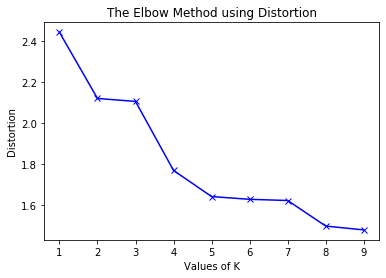

In [17]:
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 

In [18]:
k = 8
kmeans = KMeans(n_clusters=k).fit(features.iloc[:,1:])
centroids = kmeans.cluster_centers_
# print(centroids)

In [24]:
kmeans.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [19]:
#cluster representatives characteristics
pd.DataFrame(data={idx:point for idx,point in enumerate(centroids)},
            index=features.iloc[:,1:].columns)

,0,1,2,3,4,5,6,7
followers_count,35.904935,3.950000e+02,1232.129870,6697.875000,2538.000000,98227.000000,841.315193,1054.750000
friends_count,59.694700,3.480000e+02,820.766234,3358.875000,0.000000,232.000000,544.421769,0.000000
statuses_count,131.326183,1.082327e+06,44372.402597,123612.375000,2547.000000,29552.500000,12018.371882,102.250000
account_age_months,26.428784,4.727667e+01,44.332078,49.843333,18.776667,55.976667,39.722698,20.360000
statuses_per_month,7.765891,2.289347e+04,1122.822414,2708.311636,135.647080,542.692523,410.409777,12.429827
followers_ratio,19.412069,1.135025e+00,2.458696,44.984537,253800.000000,1346.993862,5.346786,105475.000000
prop_tweets,0.321124,8.646875e-01,0.463473,0.474566,0.327700,0.304847,0.447718,0.438562
prop_replies,0.114155,4.375000e-03,0.217594,0.129887,0.056884,0.436963,0.205955,0.311438
prop_rt,0.065976,1.309375e-01,0.228023,0.145547,0.615416,0.258189,0.214808,0.000000
avg_hashtags,0.093549,1.943750e-01,0.139231,0.075983,0.071723,0.094512,0.170329,0.533713


In [20]:
idx = []
for c in range(k):
    idx.append([i for i, x in enumerate(kmeans.labels_) if x == c])

In [22]:
for i in range(k):
    print(len(idx[i]))

33472
1
77
8
1
2
441
4


In [28]:
colors = ['red','black','blue','green','yellow', 'pink', 'magenta', 'cyan', 'grey', 'lightgreen']
LABEL_COLOR_MAP = {0:'r', 1:'k', 2:'b', 3:'g', 4:'y', 5:'pink', 6:'m',7:'c', 8:'grey', 9:'lightgreen'}
label_color = [LABEL_COLOR_MAP[l] for l in kmeans.labels_]

#orthogonal projection, onto space spanned by two
def plot_project1d(I,features,centroids=None):
    #idx(i) globally defined
    fig, axs = plt.subplots(4,3,figsize=(15,15))
    
    for index, i in enumerate(I):
        m,s = index%4, index//4
        for c in range(k):
            try:
                features.iloc[idx[c],i].plot.kde(label=c, ax=axs[m,s], c=colors[c])
            except:
                axs[m,s].axvline(features.iloc[idx[c],i].median(), 0,1, label=c, c=colors[c])
        axs[m,s].legend()
        axs[m,s].set_yscale('symlog')
        axs[m,s].set_xscale('symlog')
        axs[m,s].set_ylim([0, 1])
        axs[m,s].title.set_text('{}'.format(features.columns[index]))
    fig.tight_layout()
    
def plot_project2d(pairs,features,centroids):
    fig, axs = plt.subplots(4,3,figsize=(15,15))
    count = 0
    for i,j in zip(pairs[0],pairs[1]):
        m,s = count%4, count//4
        for g in np.unique(kmeans.labels_):
            if g != 7:
                axs[m,s].scatter(centroids[g, i], centroids[g, j], c=colors[g], label=g, s=100)
        #axs[m,s].scatter(features.iloc[:,i], features.iloc[:,j], marker = 'x', c=label_color, s=20, alpha=0.30)
        axs[m,s].legend()
        axs[m,s].title.set_text('{} vs {}'.format(features.columns[i],features.columns[j]))
        count += 1
        
    fig.tight_layout()

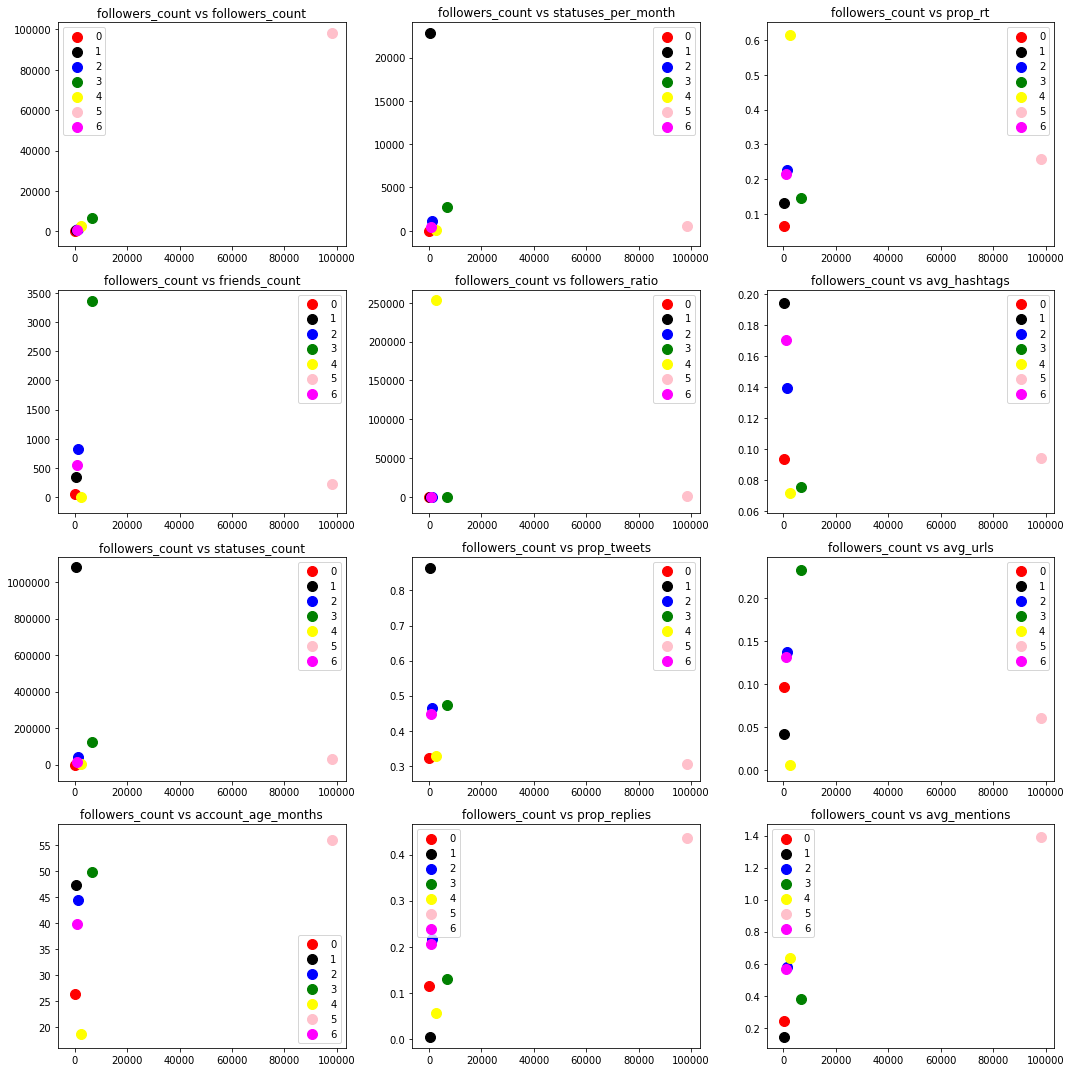

In [29]:
pairs = np.transpose([[0,i] for i in range(12)])
plot_project2d(pairs, std_df, centroids)

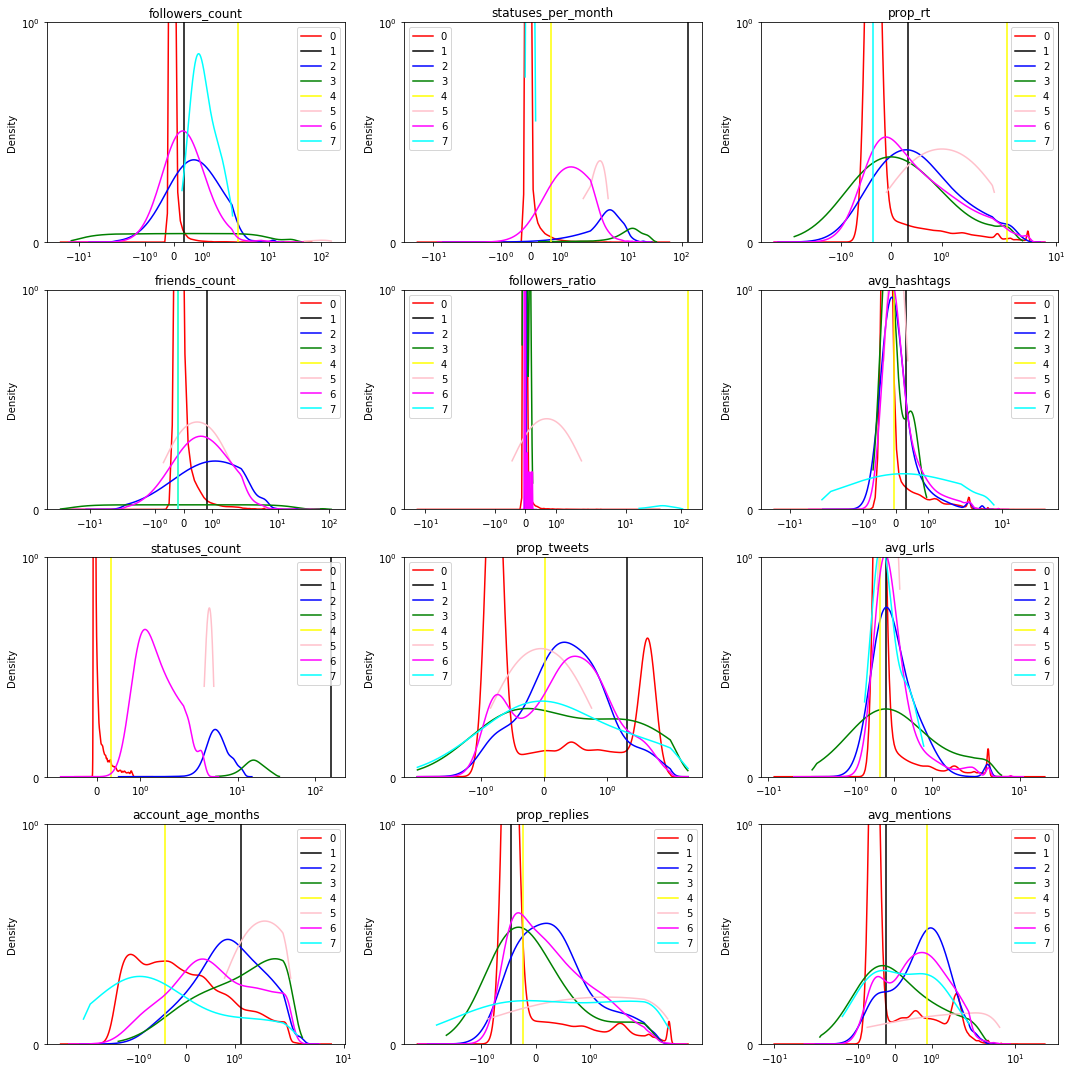

In [30]:
plot_project1d(list(range(12)), std_df, centroids)

In [31]:
# find index of the centroids
def ID_centroids(centroids):
    # global defined features
    IDs = []
    for center in centroids:
        index = np.argmin(abs(np.sum((features.iloc[:,1:].to_numpy()-center),
                             axis=1)))
        IDs.append(features['ID'][index])
    
    return IDs

In [32]:
IDs = ID_centroids(centroids)
IDs

[14424, 24567, 15880, 14276, 10449, 14276, 18656, 1614]

In [33]:
# we do a daily activity here -> can change feature to be more than activity
def find_id_evolution(ID):
    # global egotimes
    id_evolution = egotimes.loc[egotimes['egoID']==ID]
    id_evolution['created_at'] = pd.to_datetime(id_evolution['created_at'], 
                                            format='%a %b %d %H:%M:%S %z %Y')
    if (max(id_evolution['created_at']) - min(id_evolution['created_at'])).days <=1:
        print('Only one day of activity or none at all')
        return 
    
    id_evolution['n-th_day']=(id_evolution['created_at']-min(id_evolution['created_at'])).apply(lambda x: x.days)
    return id_evolution

# might be useful in some interactive plots
def plot_id_evolution(ID):
    id_evolution = find_id_evolution(ID)
    if id_evolution is None:
        ax = plt.plot()
    else:
        ax = id_evolution.groupby('n-th_day').nunique()['tweetid'].plot(label='number of tweets')
        ax = id_evolution.groupby('n-th_day').nunique()['urls'].plot(label='url usage')
        ax = id_evolution.groupby('n-th_day').nunique()['retweet_count'].plot(label='retweet count')
#    ax.set_ylabel('Number of tweets')
        ax.set_xlabel('n-th day since recorded first tweet')
        ax.set_yscale('log')
        ax.legend()


def plot_centroid_evolution(id_centroids):
    fig, axs = plt.subplots(4,2,figsize=(20,25))

    for index,id_center in enumerate(id_centroids):
        m,s = index%4, index//4
        id_evolution = find_id_evolution(id_center)
        if id_evolution is None:
            axs[m,s] = plt.plot()
#            axs[m,s][0].title.set_text('centroid #{}'.format(index))
        else:
            axs[m,s] = id_evolution.groupby('n-th_day').nunique()['tweetid'].plot(label='number of tweets',ax=axs[m,s])
            axs[m,s] = id_evolution.groupby('n-th_day').nunique()['urls'].plot(label='url usage',ax=axs[m,s])
            axs[m,s] = id_evolution.groupby('n-th_day').nunique()['retweet_count'].plot(label='retweet count',ax=axs[m,s])
            axs[m,s].set_ylim([0, 500])
            axs[m,s].legend()
            axs[m,s].set_yscale('symlog')
            axs[m,s].title.set_text('centroid #{}'.format(index))
        #axs[m,s].set_xscale('symlog')
        #axs[m,s].set_ylim([0, 1])
        #axs[m,s].title.set_text('{}'.format(features.columns[index]))

Only one day of activity or none at all
Only one day of activity or none at all


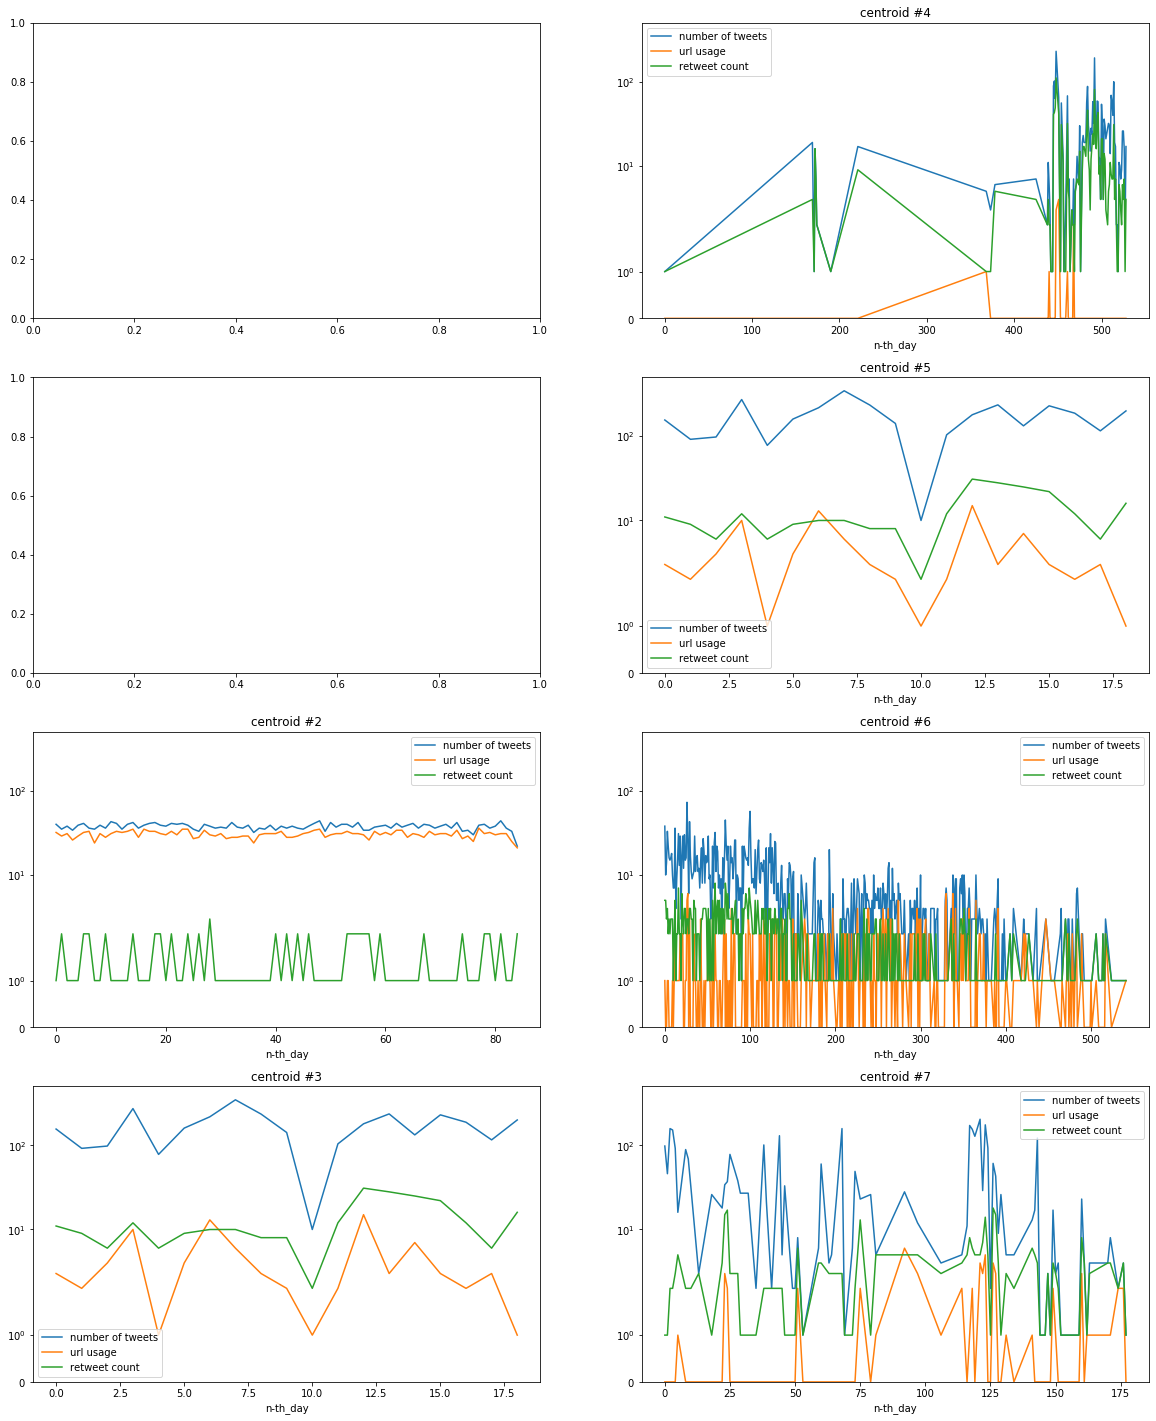

In [34]:
plot_centroid_evolution(IDs)

In [29]:
egonet = pd.read_csv('./EgoNetworks.txt',delimiter='\t')

In [30]:
def check_connect(ID1,ID2):
    # ->: means is followed by
    # 0: no direct link 
    # 1: ID1 -> ID2
    # 2: ID1 <- ID2
    # 3: ID1 <-> ID2
    
    followersID1 = set(egonet.loc[egonet['egoID']==ID1]['followerID'])
    followersID2 = set(egonet.loc[egonet['egoID']==ID2]['followerID'])
    if ID2 in followersID1:
        if ID1 in followersID2:
            return 3
        else:
            return 1
        
    elif ID1 in followersID2:
        if ID2 in followersID1:
            return 3
        else:
            return 2
    else:
        return 0

In [170]:
edges = []
for idx1,ID1 in enumerate(IDs):
    for idx2,ID2 in enumerate(IDs):
        if ID1 == ID2: continue
        ret = check_connect(ID1,ID2)
        if ret == 1: edges.append((str(idx1),str(idx2)))
        elif ret == 2: edges.append((str(idx2),str(idx1)))
        elif ret == 3: 
            edges.append((str(idx2),str(idx1)))
            edges.append((str(idx1),str(idx2)))


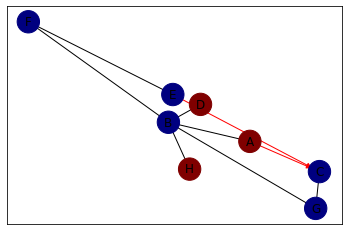

In [165]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

G = nx.DiGraph()
G.add_edges_from(
    [('A', 'B'), ('A', 'C'), ('D', 'B'), ('E', 'C'), ('E', 'F'),
     ('B', 'H'), ('B', 'G'), ('B', 'F'), ('C', 'G')])

val_map = {'A': 1.0,
           'D': 1,
           'H': 1}

values = [val_map.get(node, 0.25) for node in G.nodes()]

# Specify the edges you want here
red_edges = [('A', 'C'), ('E', 'C')]
edge_colours = ['black' if not edge in red_edges else 'red'
                for edge in G.edges()]
black_edges = [edge for edge in G.edges() if edge not in red_edges]

# Need to create a layout when doing
# separate calls to draw nodes and edges
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap('jet'), 
                       node_color = values, node_size = 500)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos, edgelist=red_edges, edge_color='r', arrows=True)
nx.draw_networkx_edges(G, pos, edgelist=black_edges, arrows=False)
plt.show()


## Interactive plots

In [139]:
!pip3 install plotly
!pip3 install chart_studio

You should consider upgrading via the 'pip install --upgrade pip' command.
     |████████████████████████████████| 71kB 1.1MB/s  eta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.


In [40]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objects as go
import chart_studio.plotly as py
init_notebook_mode(connected=True)

In [41]:
cluster_list = np.arange(k)
feature_names = features.columns.tolist()[1:]
centres = pd.DataFrame(centroids, columns=feature_names)

In [ ]:
fig = go.Figure(go.Scatter(x=centres['followers_count'], 
                           y=centres['followers_count'], 
                           mode='markers', marker_size=15, 
                           marker_color = colors[:len(centres)] ))

buttons_x = [dict(method = "restyle",
                   args = [{'y': [ centres[feature_names[c]] ]}],
                   label = feature_names[c]) for c in range(len(feature_names))]
buttons_y = [dict(method = "restyle",
                   args = [{'x': [ centres[feature_names[c]] ]}],
                   label = feature_names[c]) for c in range(len(feature_names))]

fig.update_layout(width=800, height=400,
                 updatemenus=[dict(active=0,
                                   x= 1.1, y=1, 
                                   xanchor='left', 
                                   yanchor='top',
                                   buttons=buttons_x),
                              
                               dict(active=0,
                                   x= 1.1, y=0.8, 
                                   xanchor='left', 
                                   yanchor='top',
                                   buttons=buttons_y)
                              ])  
iplot(fig)

In [42]:
fig = go.Figure(go.Scatter(x=centres['followers_count'], 
                           y=centres['followers_count'], 
                           mode='markers', marker_size=15, 
                           marker_color = colors[:len(centres)] ))

buttons_x = [dict(method = "restyle",
                   args = [{'y': [ centres[feature_names[c]] ]}],
                   label = feature_names[c]) for c in range(len(feature_names))]
buttons_y = [dict(method = "restyle",
                   args = [{'x': [ centres[feature_names[c]] ]}],
                   label = feature_names[c]) for c in range(len(feature_names))]

fig.update_layout(width=800, height=400,
                 updatemenus=[dict(active=0,
                                   x= 1.1, y=1, 
                                   xanchor='left', 
                                   yanchor='top',
                                   buttons=buttons_x),
                              
                               dict(active=0,
                                   x= 1.1, y=0.8, 
                                   xanchor='left', 
                                   yanchor='top',
                                   buttons=buttons_y)
                              ])  
iplot(fig)

In [38]:
fig.write_html("./file.html")

### t-SNE & PCA

In [43]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [345]:
X_reduced_tsne = TSNE(n_components=2, random_state=0).fit_transform(std_df)

Text(0.5, 1.0, 't-SNE')

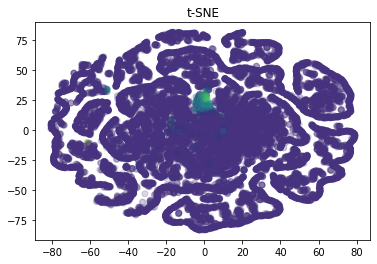

In [350]:
plt.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=kmeans.labels_, alpha=0.1)
plt.title("t-SNE")

In [44]:
X_reduced_pca = PCA(n_components=2).fit(std_df).transform(std_df)

Text(0.5, 1.0, 'PCA')

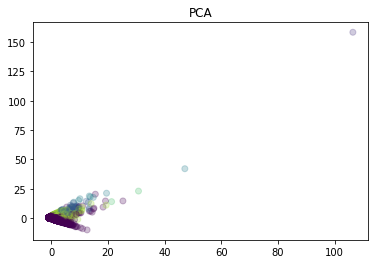

In [45]:
plt.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=kmeans.labels_, alpha=0.25)
plt.title("PCA")